In [311]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# Load the data
with open("log_NOLOAD.txt", "r") as f:
    data = f.readlines()
    columns = data[0].strip().split(', ')
    data = data[1:]

    df = pd.DataFrame([x.strip().split(', ') for x in data], columns=columns)
    
df.head()

,Position Generated,Velocity Generated,Raw Angle,Time


In [312]:
# Convert the data to the correct types
df['Position Generated'] = df['Position Generated'].astype(int)
df['Velocity Generated'] = df['Velocity Generated'].astype(float)
df['Time'] = df['Time'].astype(int)

In [313]:
df['Time'].min(), df['Time'].max()

(nan, nan)

In [314]:
# Reset Time to start at 0
df['Time'] = df['Time'] - df['Time'].min()

In [315]:
df = df[df['Time'] > 600]

df.reset_index(drop=True, inplace=True)

In [316]:
df['Time'] = df['Time'] / 1000
dfEncoder['Time'] = dfEncoder['Time'] / 1000

In [317]:
df['Time'].min(), df['Time'].max()

(nan, nan)

In [318]:
spr = 1600

df['Angle Generated'] = df['Position Generated'].apply(lambda x: x * 360 / spr)
# df['Radian'] = df['Angle'].apply(lambda x: x * 3.14159 / 180)
# df['Velocity'] = df['Velocity'] * (2 * np.pi) / spr
df['Velocity Generated'] = df['Velocity Generated'] * 0.225

In [319]:
df['Acceleration Generated'] = df['Velocity Generated'].diff() / df['Time'].diff()
df['Acceleration Generated'] = df['Acceleration Generated'].fillna(0)

df.head()

,Position Generated,Velocity Generated,Raw Angle,Time,Angle Generated,Acceleration Generated


In [320]:
df['Raw Angle'].value_counts().idxmax()

ValueError: attempt to get argmax of an empty sequence

<Axes: title={'center': 'Angle vs Time'}, xlabel='Time'>

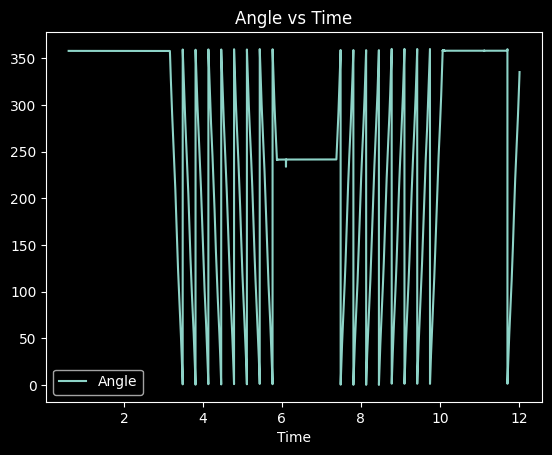

In [ ]:
# Map raw angle (0-4095) to degrees (0-360)
df['Angle Encoder'] = df['Raw Angle'] / 4095 * 360

df.plot(x='Time', y='Angle Encoder', title='Angle vs Time (Encoder)')

<Axes: title={'center': 'Angle vs Time'}, xlabel='Time'>

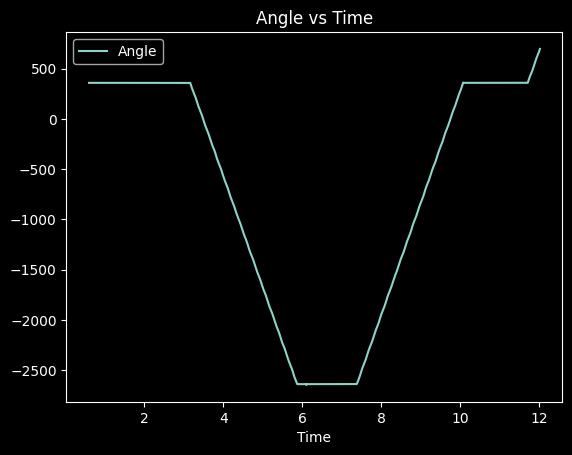

In [ ]:
# Continuous angle
continuous_angle = [df['Angle Encoder'].iloc[0]]

# Calculate into continuous angle
for i in range(1, len(df)):
    delta_angle = df['Angle Encoder'][i] - df['Angle Encoder'][i - 1]
    if delta_angle > 180:
        delta_angle -= 360
    elif delta_angle < -180:
        delta_angle += 360

    continuous_angle.append(continuous_angle[-1] + delta_angle)

df['Angle Encoder'] = continuous_angle

df.plot(x='Time', y='Angle', title='Angle vs Time (Encoder)')

In [ ]:
#calibrate the encoder
df['Angle Encoder'] = df['Angle Encoder'] - df['Angle Encoder'].iloc[0]

<Axes: title={'center': 'Angle vs Time'}, xlabel='Time'>

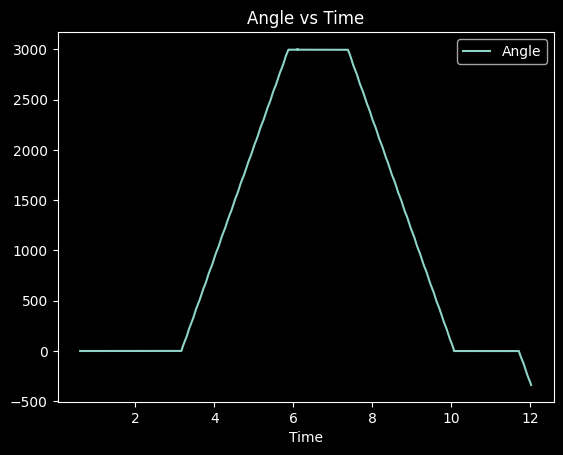

In [ ]:
# Change direction of angle
df['Angle Encoder'] = -df['Angle Encoder']

df.plot(x='Time', y='Angle', title='Angle vs Time (Encoder)')

In [ ]:
# dfEncoder['Radian'] = np.deg2rad(dfEncoder['Angle'])
# dfEncoder['Velocity'] = dfEncoder['Radian'].diff() / dfEncoder['Time'].diff()
df['Velocity Encoder'] = df['Angle Encoder'].diff() / df['Time'].diff()
df['Velocity Encoder'] = df['Velocity Encoder'].fillna(0)

df['Acceleration Encoder'] = df['Velocity Encoder'].diff() / df['Time'].diff()
df['Acceleration Encoder'] = df['Acceleration Encoder'].fillna(0)

df.head()

,Raw Angle,Time,Match Flag,Started,Angle,Velocity,Acceleration
0,4071,0.601,0,1,-0.000000,0.000000,0.000000
1,4071,0.602,0,1,-0.000000,0.000000,0.000000
2,4071,0.603,0,1,-0.000000,0.000000,0.000000
3,4071,0.604,0,1,-0.000000,0.000000,0.000000
4,4072,0.605,0,1,-0.087912,-87.912088,-87912.087912


In [ ]:
# columnsDF = ['Position', 'Angle', 'Radian', 'Velocity', 'Acceleration', 'Started', 'Time']
# columnsDFEncoder = ['Raw Angle', 'Angle', 'Radian', 'Velocity', 'Acceleration', 'Match Flag', 'Started', 'Time']

columnsDF = ['Position Generated', 'Velocity Generated', 'Acceleration Generated', 'Raw Angle', 'Angle Encoder', 'Velocity Encoder', 'Acceleration Encoder', 'Time']

df = df[columnsDF]

# **GRAPH**

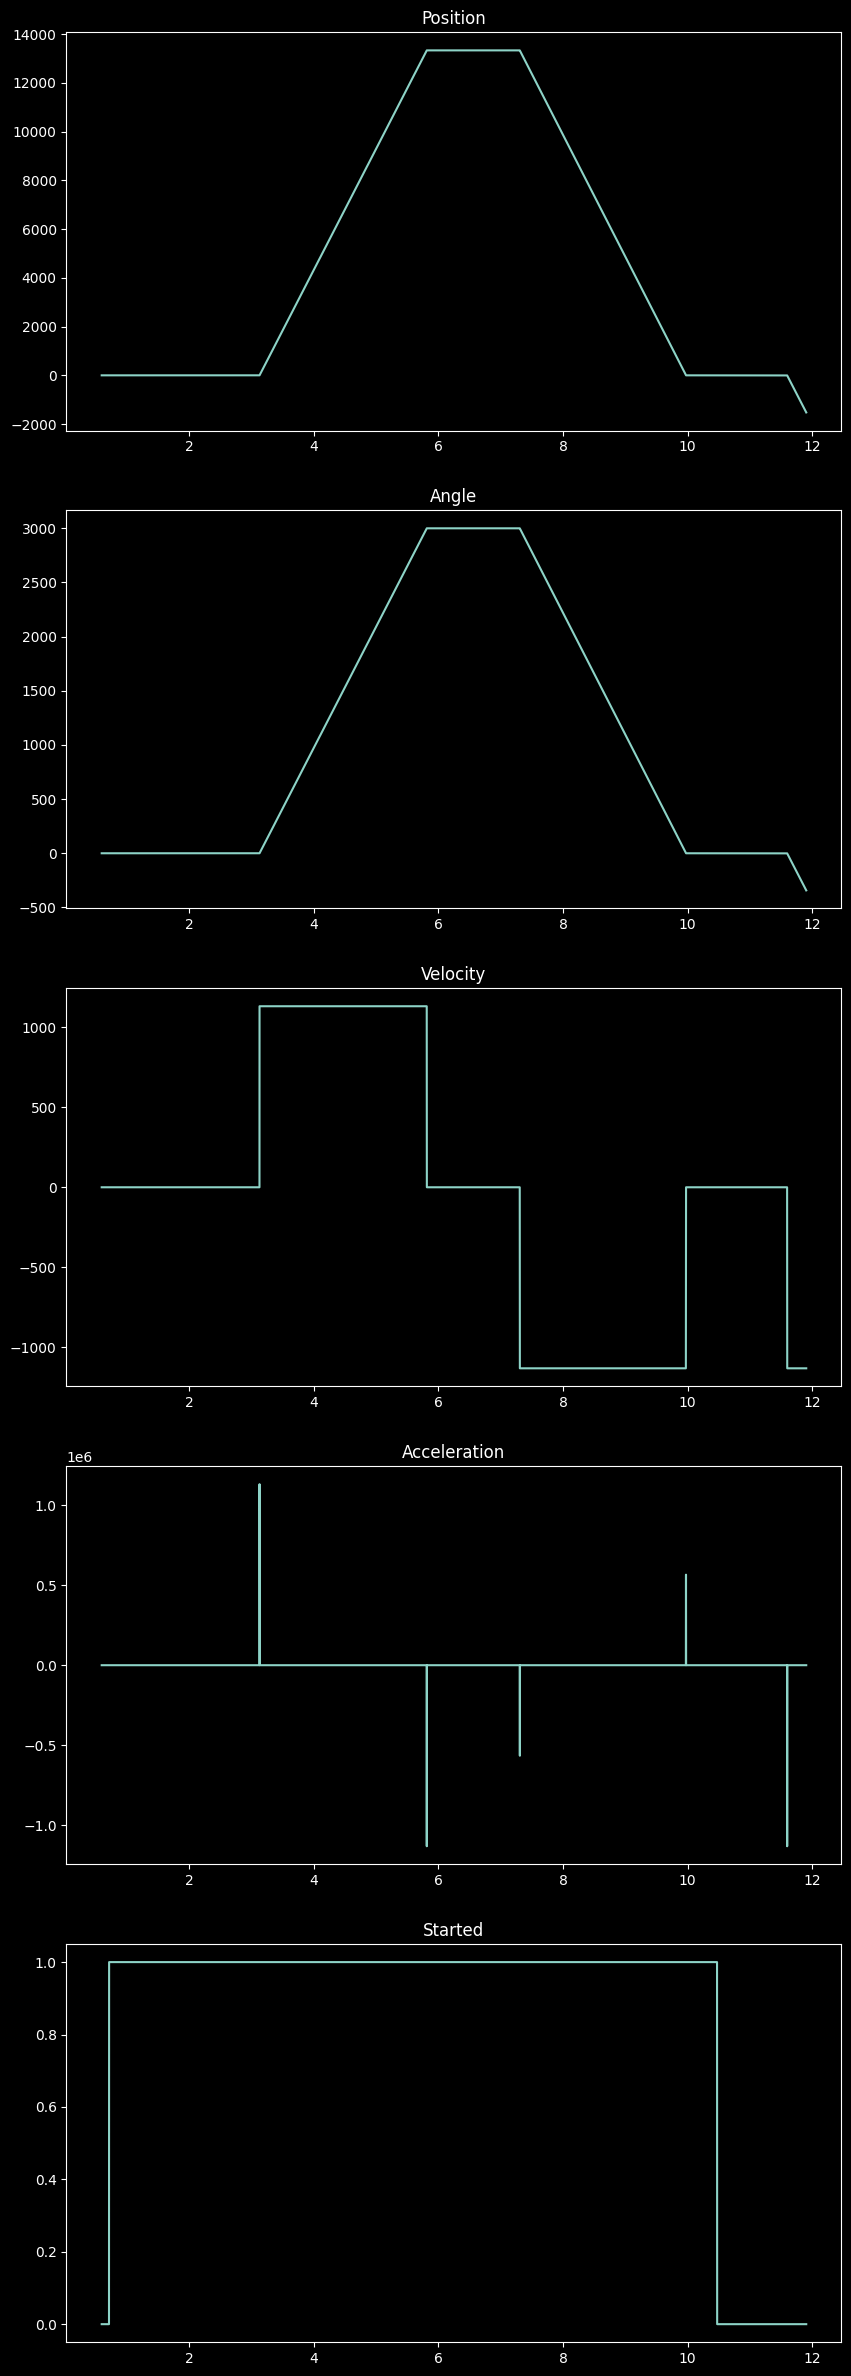

In [ ]:
fig, ax = plt.subplots((len(columnsDF) - 1) / 2, 2, figsize=(10, 30))
for i, col in enumerate(columnsDF):
    if col == 'Time':
        continue
    ax[i // 2, i % 2].plot(df['Time'], df[col])
    ax[i // 2, i % 2].set_title(col)

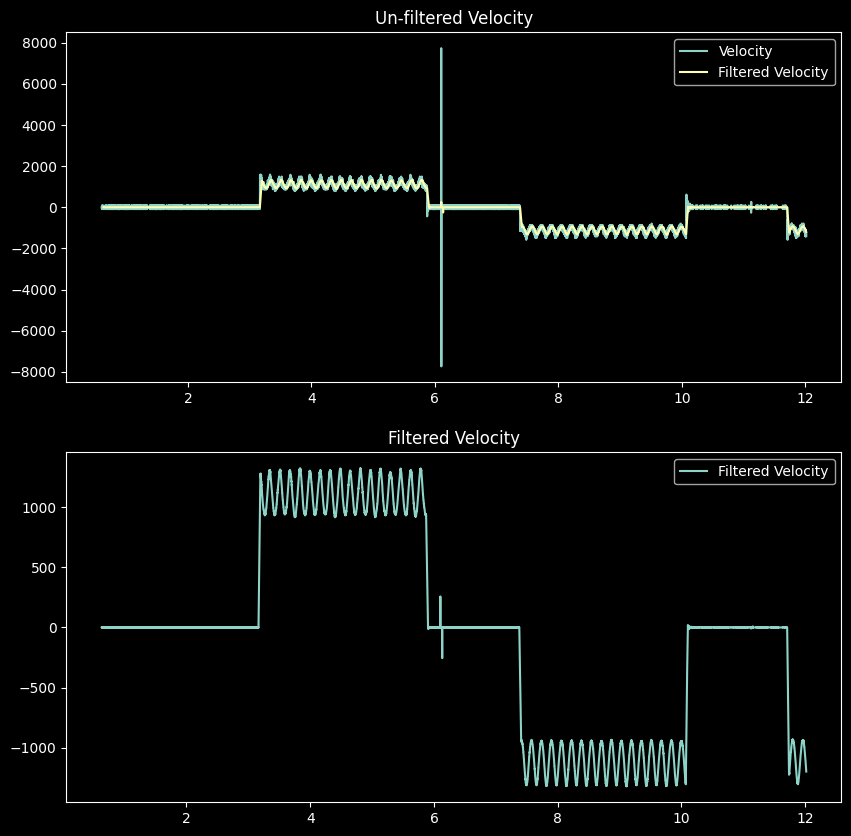

In [ ]:
dfCopy = df.copy()

# Apply low pass filter
dfCopy['Velocity Encoder Filtered'] = dfCopy['Velocity Encoder'].rolling(window=30).mean()

fig, ax = plt.subplots(2, 1, figsize=(10, 10))
ax[0].plot(dfCopy['Time'], dfCopy['Velocity Encoder'])
ax[0].plot(dfCopy['Time'], dfCopy['Velocity Encoder Filtered'])
ax[1].plot(dfCopy['Time'], dfCopy['Velocity Encoder Filtered'])

ax[0].set_title('Un-filtered Velocity (Encoder)')
ax[1].set_title('Filtered Velocity (Encoder)')

ax[0].legend(['Velocity', 'Filtered Velocity'])
ax[1].legend(['Filtered Velocity'])

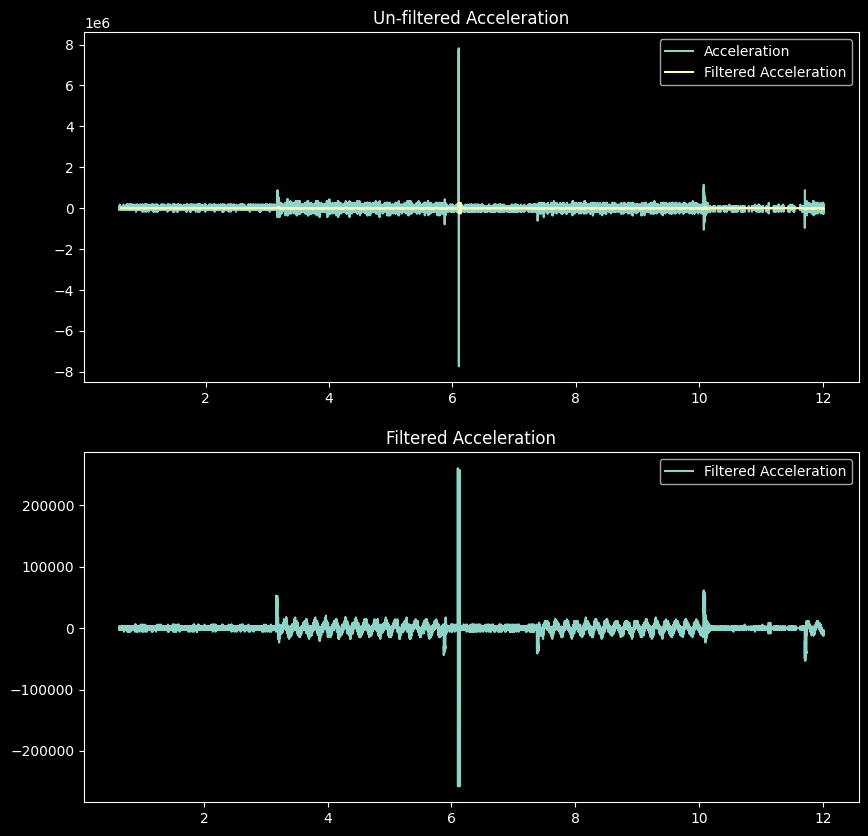

In [ ]:
dfCopy['Acceleration Encoder Filtered'] = dfCopy['Acceleration Encoder'].rolling(window=30).mean()

fig, ax = plt.subplots(2, 1, figsize=(10, 10))
ax[0].plot(dfCopy['Time'], dfCopy['Acceleration Encoder'])
ax[0].plot(dfCopy['Time'], dfCopy['Acceleration Encoder Filtered'])
ax[1].plot(dfCopy['Time'], dfCopy['Acceleration Encoder Filtered'])

ax[0].set_title('Un-filtered Acceleration (Encoder)')
ax[1].set_title('Filtered Acceleration (Encoder)')

ax[0].legend(['Acceleration', 'Filtered Acceleration'])
ax[1].legend(['Filtered Acceleration'])

In [ ]:
dfCopy.max()

Raw Angle                4.095000e+03
Angle                    3.004132e+03
Velocity                 7.736264e+03
Acceleration             7.824176e+06
Match Flag               1.000000e+00
Started                  1.000000e+00
Time                     1.201600e+01
Velocity Filtered        1.324542e+03
Acceleration Filtered    2.608059e+05
dtype: float64

In [ ]:
df3_4sec = df[df['Time'] >= 3]
df3_4sec = df3_4sec[df3_4sec['Time'] <= 4]

# fig, ax = plt.subplots(2, 1, figsize=(10, 10))
# ax[0].plot(df3_4sec['Time'], df3_4sec['Velocity'])
# ax[1].plot(df3_4sec['Time'], df3_4sec['Acceleration'])

df3_4sec.max()

Position        4.302000e+03
Angle           9.679500e+02
Velocity        1.130893e+03
Acceleration    1.130893e+06
Started         1.000000e+00
Time            3.999000e+00
dtype: float64

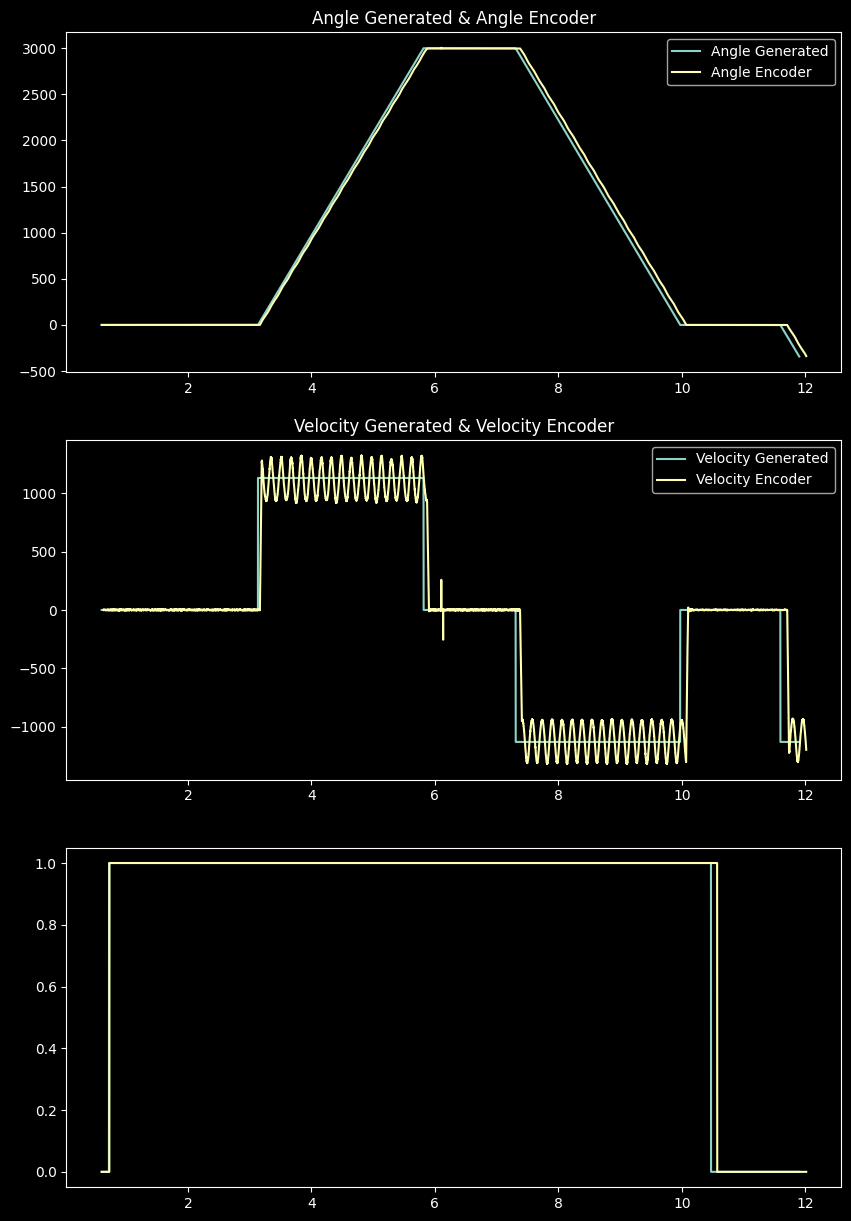

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(10, 15))
ax[0].plot(df['Time'], df['Angle Generated'])
ax[1].plot(df['Time'], df['Velocity Generated'])
ax[0].plot(df['Time'], df['Angle Encoder'])
ax[1].plot(dfCopy['Time'], dfCopy['Velocity Encoder Filtered'])

ax[0].set_title('Angle Generated & Angle Encoder')
ax[1].set_title('Velocity Generated & Velocity Encoder')

ax[0].legend(['Angle Generated', 'Angle Encoder'])
ax[1].legend(['Velocity Generated', 'Velocity Encoder'])